## Analysis
Do the following analyses:
1. Plot mean rewards together for all runs by task
2. Plot success rate together for all runs by task
3. Plot Quantile of rewards together for all runs by task
4. Evaluate gating values and performance

Need a way of splitting out algorithm, task, run

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
EXPERIMENT_LOG = '../../experiment_log.csv'
experiment_log = pd.read_csv(EXPERIMENT_LOG)


In [30]:
## create resultSets for push-v2 envs
experiments = (
    experiment_log
    .query('(environment=="push-v2") & (latest=="Y") & (setting=="random") & (~file_location.isna())')
)

file_dict = (
    experiments
    .loc[:,['file_location', 'algorithm']]
    .set_index('algorithm')
    .to_dict()['file_location']
)


all_results = {name: resultSet(root = os.path.join('../logs', file),name = name) for name, file in file_dict.items()}


In [36]:
all_results['random'].data

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,rq_0.1,rq_0.2,rq_0.3,rq_0.4,rq_0.5,...,gq_0.3,gq_0.4,gq_0.5,gq_0.6,gq_0.7,gq_0.8,gq_0.9,frame,result_group,run_name
0,push-v2,push-v2,0.0,8,0.036078,0.035765,0.035852,0.035928,0.035993,0.036074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000,train_results,random
1,push-v2,push-v2,0.0,8,0.035968,0.035626,0.035747,0.035843,0.035926,0.035999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000,train_results,random
2,push-v2,push-v2,0.0,8,0.039641,0.035658,0.035736,0.035786,0.035850,0.035935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12000,train_results,random
3,push-v2,push-v2,0.0,8,0.036045,0.035720,0.035829,0.035896,0.035981,0.036059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000,train_results,random
4,push-v2,push-v2,0.0,8,0.036026,0.035742,0.035810,0.035867,0.035925,0.035990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000,train_results,random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,push-v2,push-v2,0.0,8,0.036078,0.035761,0.035839,0.035918,0.035979,0.036034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2984000,train_results,random
746,push-v2,push-v2,0.0,8,0.036055,0.035756,0.035843,0.035889,0.035927,0.035979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2988000,train_results,random
747,push-v2,push-v2,0.0,8,0.036011,0.035744,0.035825,0.035891,0.035958,0.036019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2992000,train_results,random
748,push-v2,push-v2,0.0,8,0.035938,0.035701,0.035761,0.035802,0.035841,0.035887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2996000,train_results,random


In [61]:
class resultsManager:

    def __init__(self, experiment_log_loc, environment, setting='random'):
        self.experiments = (
            pd.read_csv(experiment_log_loc)
            .query(f'(environment=="{environment}") & (latest=="Y") & (setting=="{setting}") & (~file_location.isna())')
            .loc[:,['file_location', 'algorithm']]
            .set_index('algorithm')
            .to_dict()['file_location']
        )
        self.environment = environment
        self.setting = setting
        self.data = {name: resultSet(root = os.path.join('../logs', file), name = name) \
            for name, file in self.experiments.items()}

        self.random_baseline = self.calculate_baseline('random')
        self.right_only_single_baseline = self.calculate_baseline('right_only')
        # self.right_only_double_baseline = None ## need to create this still

    def calculate_baseline(self, name):
        # assumes right_only / random have only train data
        reward_mean = (
            self.data[name]
            .data
            .query('result_group=="train_results"')
            .loc[:, 'reward_mean']
            .mean()
        )
        success_rate = (
            self.data[name]
            .data
            .query('result_group=="train_results"')
            .loc[:, 'num_successes']
            .mean()
        )
        return (reward_mean, success_rate)

    def get_result_group_data(self, result_group):
        return (
            pd.concat(
                [self.data[k].data.query(f'result_group=="{result_group}"') for k in self.data.keys()]
                )
            .drop(['num_episodes', 'evaluation_task'], axis =1) 
        )
            
class resultSet:

    def __init__(self, root, name):
        self.root = root
        self.name = name
        self.contents = os.listdir(self.root)
        self.data = self.collect_results()

    def collect_results(self):
        train_results = self.read_if_exists('train_results.csv')
        test_results = self.read_if_exists('test_results.csv')
        left_eval_results = self.read_if_exists('left_eval_results.csv')

        combined_results = (
            pd.concat([train_results, test_results, left_eval_results])
            .assign(run_name = self.name)
        )

        return combined_results

    def read_if_exists(self, path):
        
        if path in self.contents:
            result = (
                pd.read_csv(os.path.join(self.root, path))
                .assign(result_group = path.replace('.csv', ''))
            )
        else:
            result = None
        
        return result


In [62]:
push_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='push-v2', setting='random')

In [ ]:
## create baseline plot for right

In [156]:
test_data = push_experiments.get_result_group_data('test_results')
train_data = push_experiments.get_result_group_data('train_results')


In [ ]:
## get data
## make plots
## rewards, successes, gating values

In [221]:
def plot_rew_and_succ(data, alpha = 1, figsize=(20,7)):

    plot_df = (
        data
        .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
        .query('variable.isin(["reward_mean", "num_successes"])')
        .set_index('frame')
        .groupby(['training_task', 'result_group', 'run_name', 'variable'])
        .apply(lambda x: x[['value']].ewm(alpha=alpha).mean())
        .reset_index()
    )

    fig, ax = plt.subplots(1, 2, figsize=figsize)

    create_lineplot(
        data = plot_df.query('variable=="reward_mean"'),
        title = "Mean Rewards",
        ax=ax[0]
    )

    create_lineplot(
        data = plot_df.query('variable=="num_successes"'),
        title = 'Success Rate',
        ax = ax[1]
    )
    # # sns.lineplot(
    # #     data = plot_df.query('variable=="reward_mean"'),
    # #     x = 'frame',
    # #     y = 'value',
    # #     hue='run_name',
    # #     ax = ax[0]
    # # )

    # sns.lineplot(
    #     data = plot_df.query('variable=="num_successes"'),
    #     x = 'frame',
    #     y = 'value',
    #     hue='run_name',
    #     ax = ax[1]
    # )

    plt.tight_layout()
    plt.show();

In [222]:
def create_lineplot(data, title, ax):

    sns.lineplot(
        data = data,
        x = 'frame',
        y = 'value',
        hue = 'run_name',
        ax = ax
    )
    ## perhaps add axis names?
    ax.set_title(title)

def plot_rew_quantiles(data, alpha=1, figsize = (20, 7)):

    plot_df = (
        data
        .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
        .query('variable.isin(["rq_0.1", "rq_0.5", "rq_0.9"])')
        .set_index('frame')
        .groupby(['training_task', 'result_group', 'run_name', 'variable'])
        .apply(lambda x: x[['value']].ewm(alpha=alpha).mean())
        .reset_index()
    )

    fig, ax = plt.subplots(1, 3, figsize=figsize)

    create_lineplot(
        plot_df.query('variable=="rq_0.1"'),
        title="0.1 Quantile Rewards",
        ax = ax[0]
    )
    create_lineplot(
        plot_df.query('variable=="rq_0.5"'),
        title="0.5 Quantile Rewards",
        ax = ax[1]
    )
    create_lineplot(
        plot_df.query('variable=="rq_0.9"'),
        title="0.9 Quantile Rewards",
        ax = ax[2]
    )

    plt.tight_layout()
    plt.show();

In [217]:
def plot_gating_values(data, title, alpha = 1, figsize = (20, 7)):

    gating_quantiles = [f"gq_{i/10}" for i in range(1, 10)]

    plot_df = (
        data
        .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
        .query(f'variable.isin({gating_quantiles})')
        .set_index('frame')
        .groupby(['training_task', 'result_group', 'run_name', 'variable'])
        .apply(lambda x: x[['value']].ewm(alpha=alpha).mean())
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)
    create_lineplot(
        data = plot_df,
        title=title,
        ax = ax
    )

    plt.show();

    

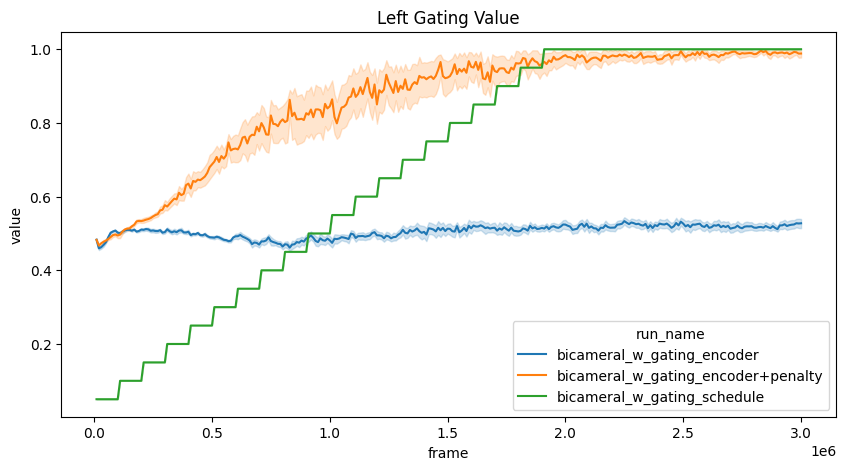

In [220]:
plot_gating_values(train_data.query("run_name.str.contains('bicameral')"), title = "Left Gating Value", figsize = (10, 5))

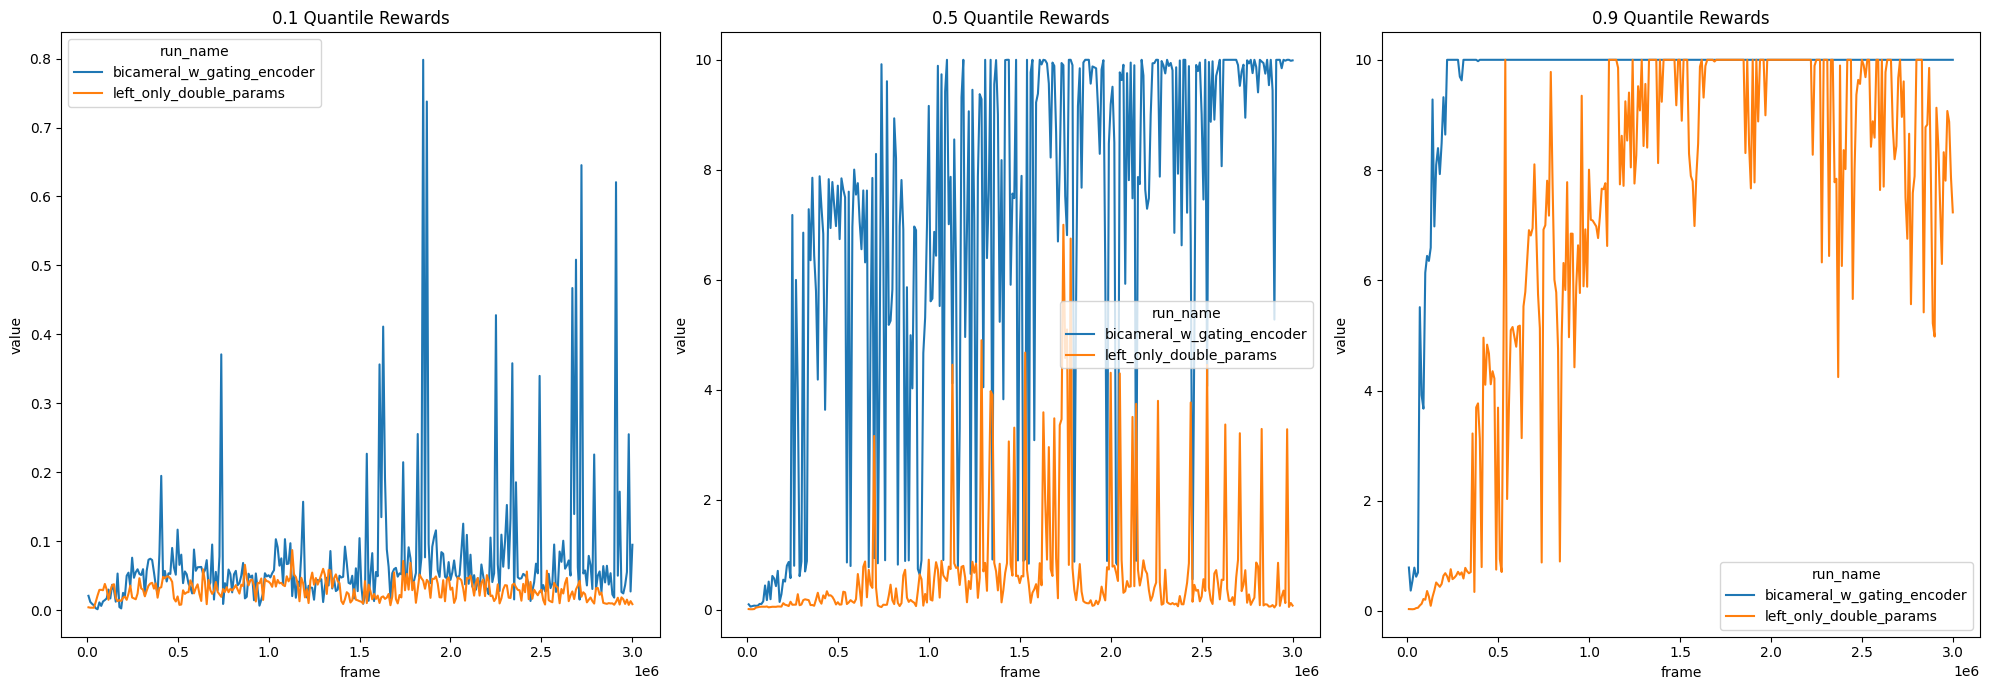

In [223]:
plot_rew_quantiles(train_data.query('run_name.isin(["bicameral_w_gating_encoder", "left_only_double_params"])'), alpha = 1)

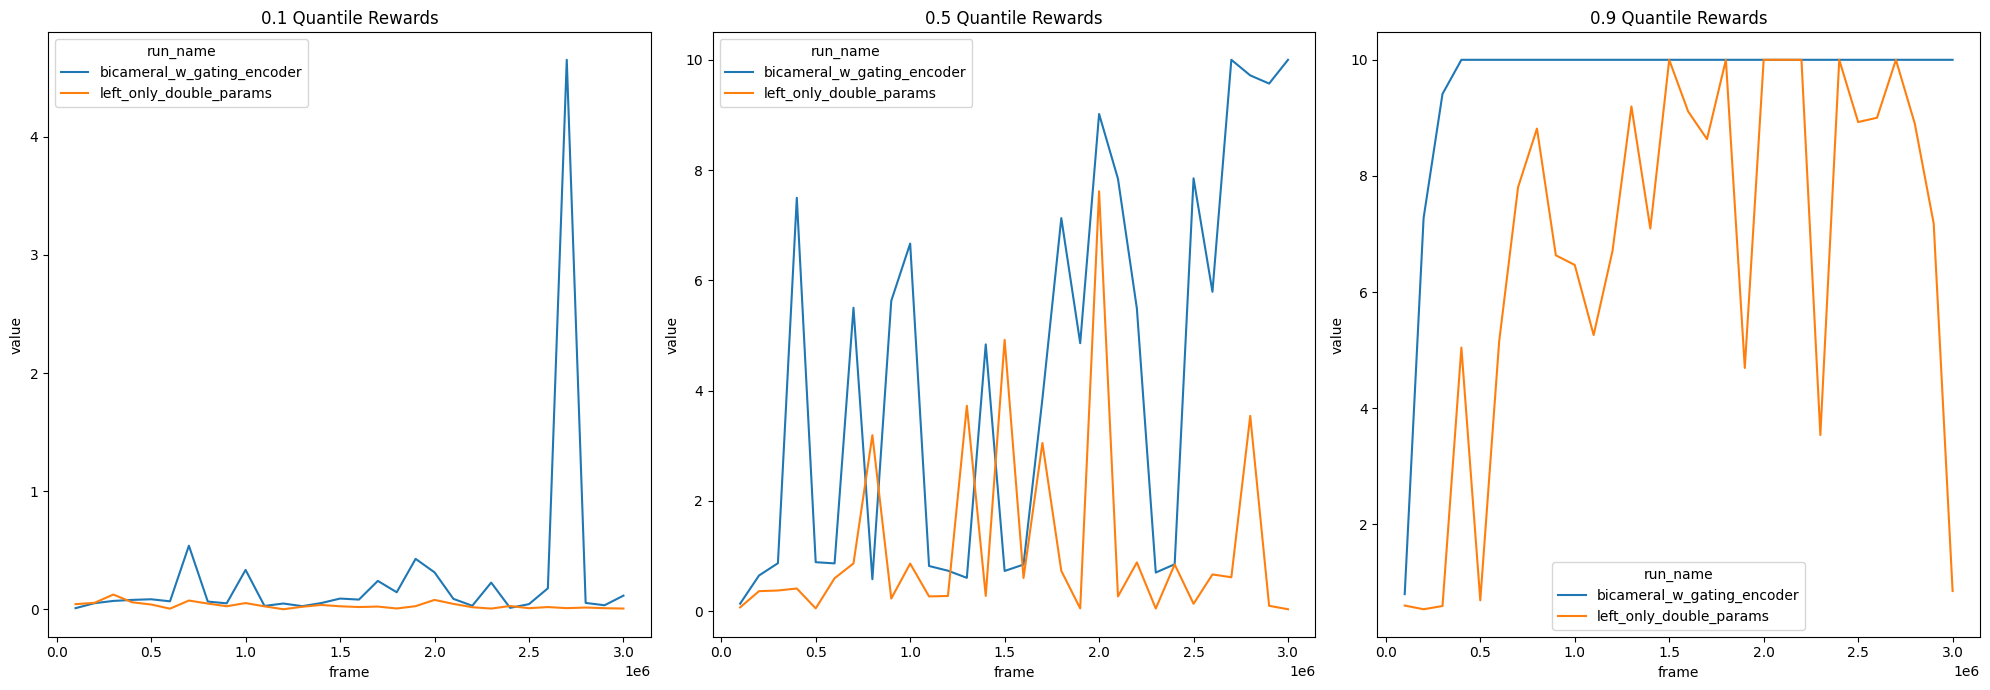

In [224]:
plot_rew_quantiles(test_data.query('run_name.isin(["bicameral_w_gating_encoder", "left_only_double_params"])'), alpha = 1)

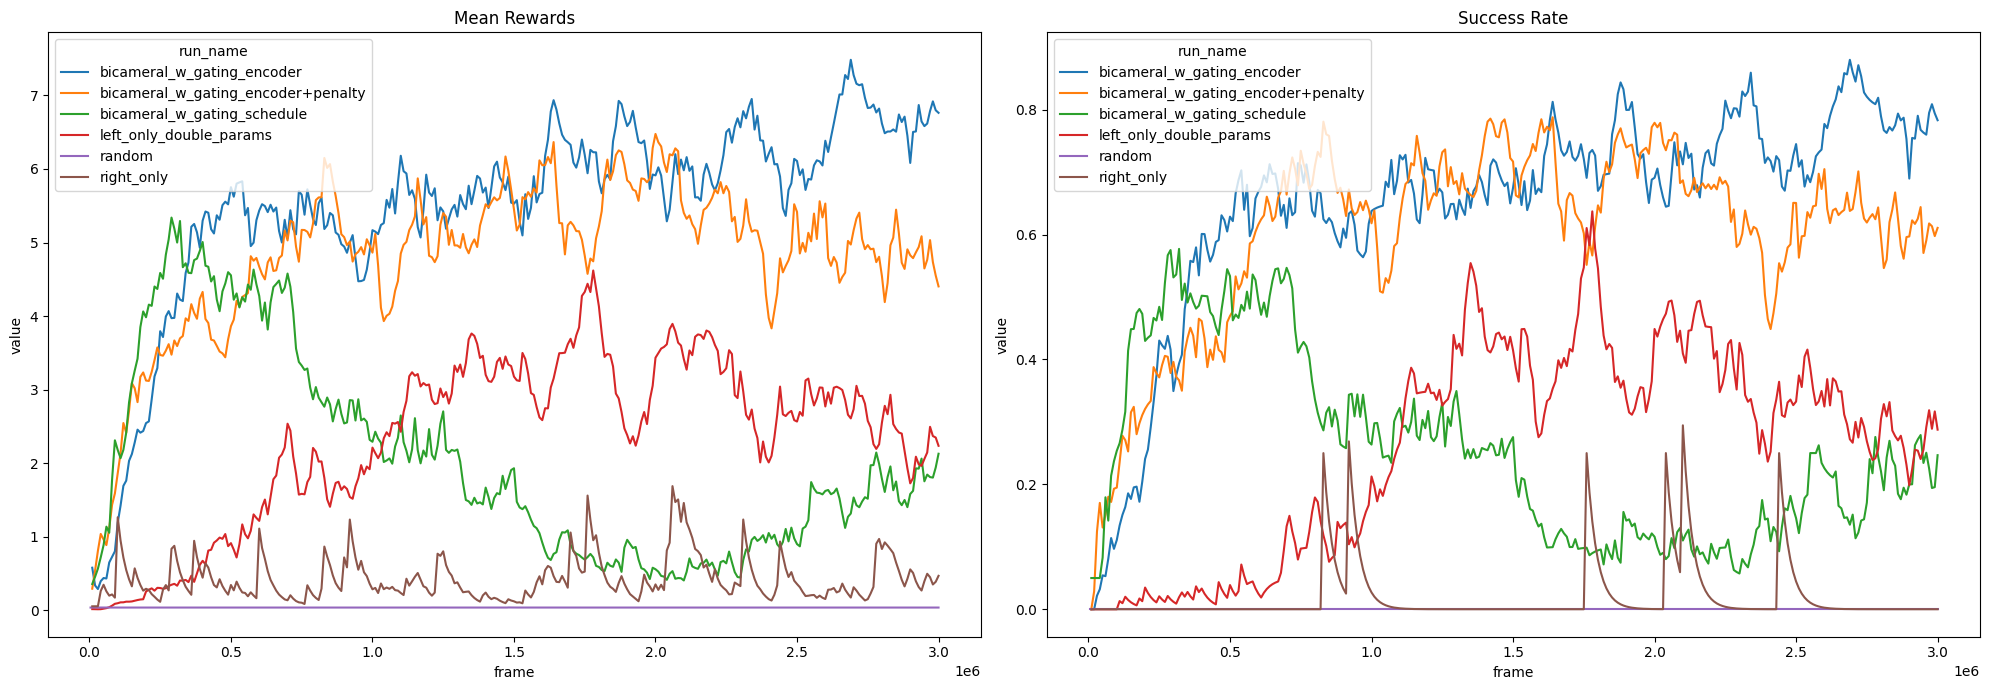

In [225]:
plot_rew_and_succ(train_data, alpha = .25)

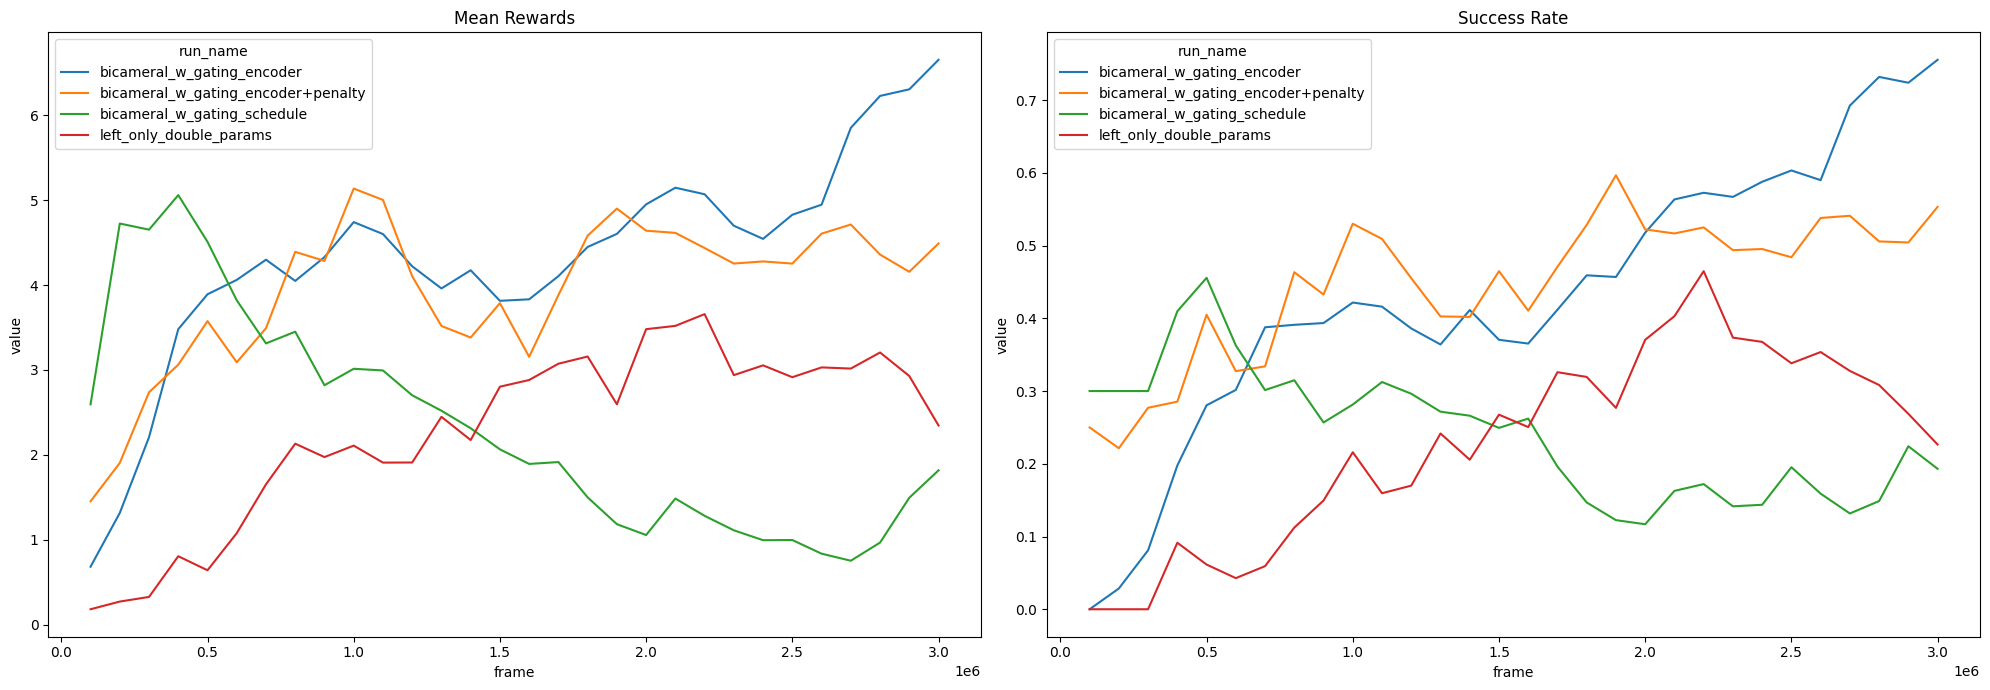

In [226]:
plot_rew_and_succ(test_data, alpha = .25)

In [132]:
ewma_result = (
    train_data
    .query('~run_name.isin(["random","right_only", "left_only_double_params"])')
    .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
    .query(f'(variable.isin({gate_quantiles}))')
    .set_index('frame')
    .groupby(['training_task', 'result_group', 'run_name', 'variable'])
    .apply(ewma_group)
    .reset_index()
    .melt(
        id_vars = ['training_task', 'result_group', 'run_name', 'variable'],
        var_name = 'frame'
    )
)

ewma_result

ValueError: value_name (value) cannot match an element in the DataFrame columns.

<Axes: xlabel='frame', ylabel='value'>

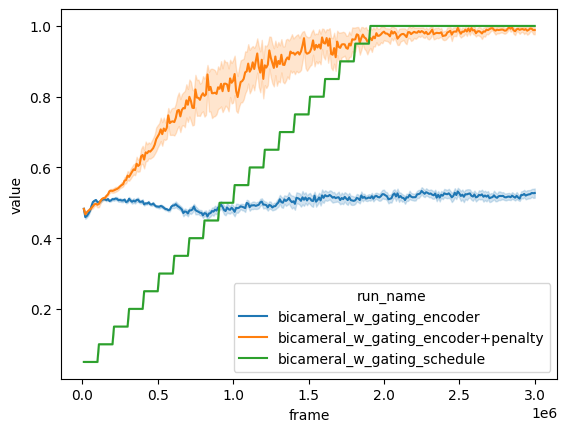

In [131]:
import pandas as pd

# Define a function to calculate EWMA for each group
def ewma_group(group):
    return group['value'].ewm(alpha=1).mean()  # Adjust span as needed

# Apply EWMA calculation over groups
ewma_result = (
    train_data
    .query('~run_name.isin(["random","right_only", "left_only_double_params"])')
    .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
    .query(f'(variable.isin({gate_quantiles}))')
    .set_index('frame')
    .groupby(['training_task', 'result_group', 'run_name', 'variable'])
    .apply(ewma_group)
    .reset_index()
    .melt(
        id_vars = ['training_task', 'result_group', 'run_name', 'variable'],
        var_name = 'frame'
    )
)

# print(ewma_result)

sns.lineplot(
    data = ewma_result,
    x = 'frame',
    y = 'value',
    hue = 'run_name'
)

In [125]:
ewma_result

frame,training_task,result_group,run_name,variable,10000,20000,30000,40000,50000,60000,...,2910000,2920000,2930000,2940000,2950000,2960000,2970000,2980000,2990000,3000000
0,push-v2,train_results,bicameral_w_gating_encoder,gq_0.1,0.477823,0.463113,0.459628,0.459256,0.461746,0.466521,...,0.497728,0.497898,0.498451,0.498261,0.498007,0.498108,0.498195,0.498666,0.498456,0.498166
1,push-v2,train_results,bicameral_w_gating_encoder,gq_0.2,0.478897,0.464710,0.461333,0.461093,0.463558,0.468186,...,0.504579,0.504771,0.505299,0.504874,0.504671,0.504875,0.505267,0.506088,0.505551,0.505378
2,push-v2,train_results,bicameral_w_gating_encoder,gq_0.3,0.479714,0.465935,0.462694,0.462713,0.465206,0.469702,...,0.508376,0.508659,0.509090,0.509104,0.509538,0.509795,0.510004,0.510717,0.511391,0.512015
3,push-v2,train_results,bicameral_w_gating_encoder,gq_0.4,0.480604,0.467276,0.464250,0.464611,0.467053,0.471394,...,0.510727,0.511104,0.511602,0.511982,0.512515,0.512878,0.513187,0.513829,0.514475,0.515359
4,push-v2,train_results,bicameral_w_gating_encoder,gq_0.5,0.481668,0.468890,0.466285,0.466808,0.469179,0.473347,...,0.512967,0.513520,0.514032,0.514377,0.514927,0.515337,0.515722,0.516473,0.517216,0.518175
5,push-v2,train_results,bicameral_w_gating_encoder,gq_0.6,0.482676,0.470909,0.468682,0.469173,0.471374,0.475374,...,0.516403,0.516953,0.517637,0.517992,0.518576,0.519060,0.519588,0.520312,0.521159,0.522144
6,push-v2,train_results,bicameral_w_gating_encoder,gq_0.7,0.484035,0.473749,0.471355,0.471942,0.473787,0.477652,...,0.522280,0.522768,0.523647,0.523953,0.524506,0.525085,0.525951,0.526933,0.528098,0.529150
7,push-v2,train_results,bicameral_w_gating_encoder,gq_0.8,0.488524,0.478188,0.475128,0.475366,0.476756,0.480692,...,0.532773,0.533388,0.534773,0.535054,0.535667,0.536616,0.537646,0.538789,0.540337,0.541328
8,push-v2,train_results,bicameral_w_gating_encoder,gq_0.9,0.492991,0.482478,0.479796,0.481507,0.482321,0.486223,...,0.550579,0.551418,0.552357,0.552775,0.553293,0.554064,0.554534,0.555146,0.555874,0.556379
9,push-v2,train_results,bicameral_w_gating_encoder+penalty,gq_0.1,0.477630,0.466747,0.464321,0.462732,0.463913,0.466982,...,0.960582,0.961055,0.959900,0.959360,0.958278,0.957894,0.958366,0.959182,0.958297,0.957508


<Axes: xlabel='frame', ylabel='value'>

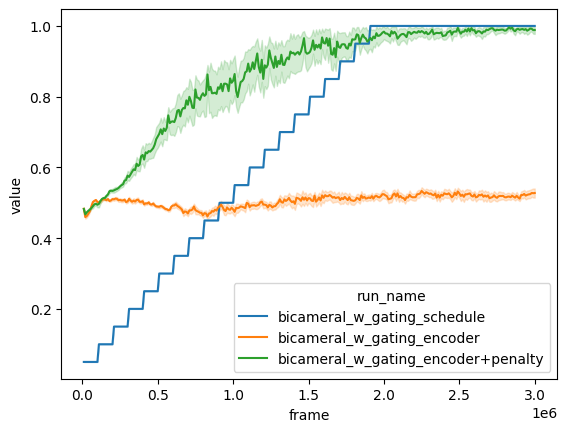

In [113]:
gate_quantiles = [f'gq_{i/10}' for i in range(1, 10)]
k = (
        train_data
        .query('~run_name.isin(["random","right_only", "left_only_double_params"])')
        .melt(id_vars=['training_task', 'frame', 'result_group', 'run_name'])
        .query(f'(variable.isin({gate_quantiles}))')

)


sns.lineplot(
    data = k,
    x = 'frame',
    y = 'value',
    hue = 'run_name'
)

<Axes: xlabel='frame', ylabel='num_successes'>

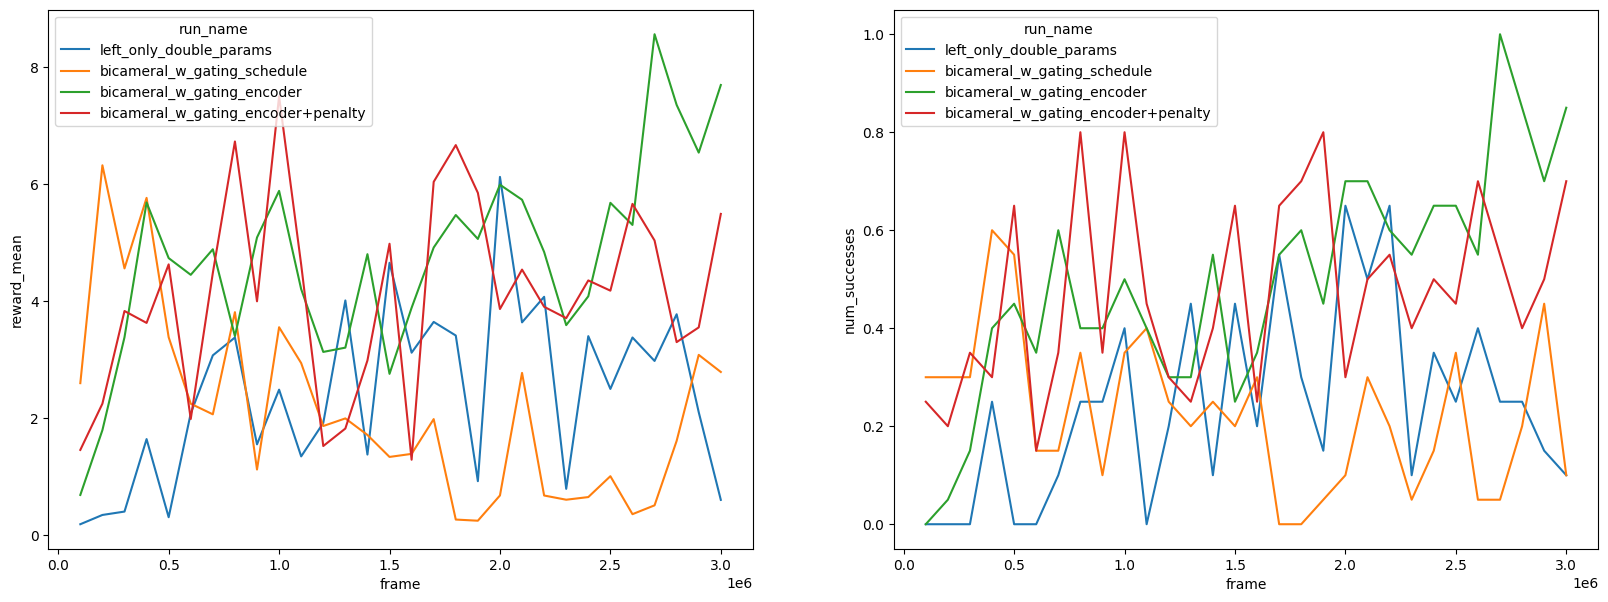

In [65]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

sns.lineplot(
    test_data,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

sns.lineplot(
    test_data,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]
)

In [60]:
push_experiments.right_only_single_baseline

(0.4297083568033334, 0.02)

In [41]:
## plot training comparison - reward_mean, num_successes, reward_quantiles
## for train
train_results = (
    pd.concat(
        [all_results[k].data.query('result_group=="train_results"') for k in all_results.keys()]
    )
    .drop(['num_episodes', 'training_task', 'evaluation_task'], axis =1)
    .melt(id_vars = ['run_name', 'frame', 'result_group'])
)

## for test
## for test vs left
## note use right / random baselines for all

In [46]:
reward_quantiles = [f"rq_{i/10}" for i in range(1, 10)]

<Axes: xlabel='frame', ylabel='value'>

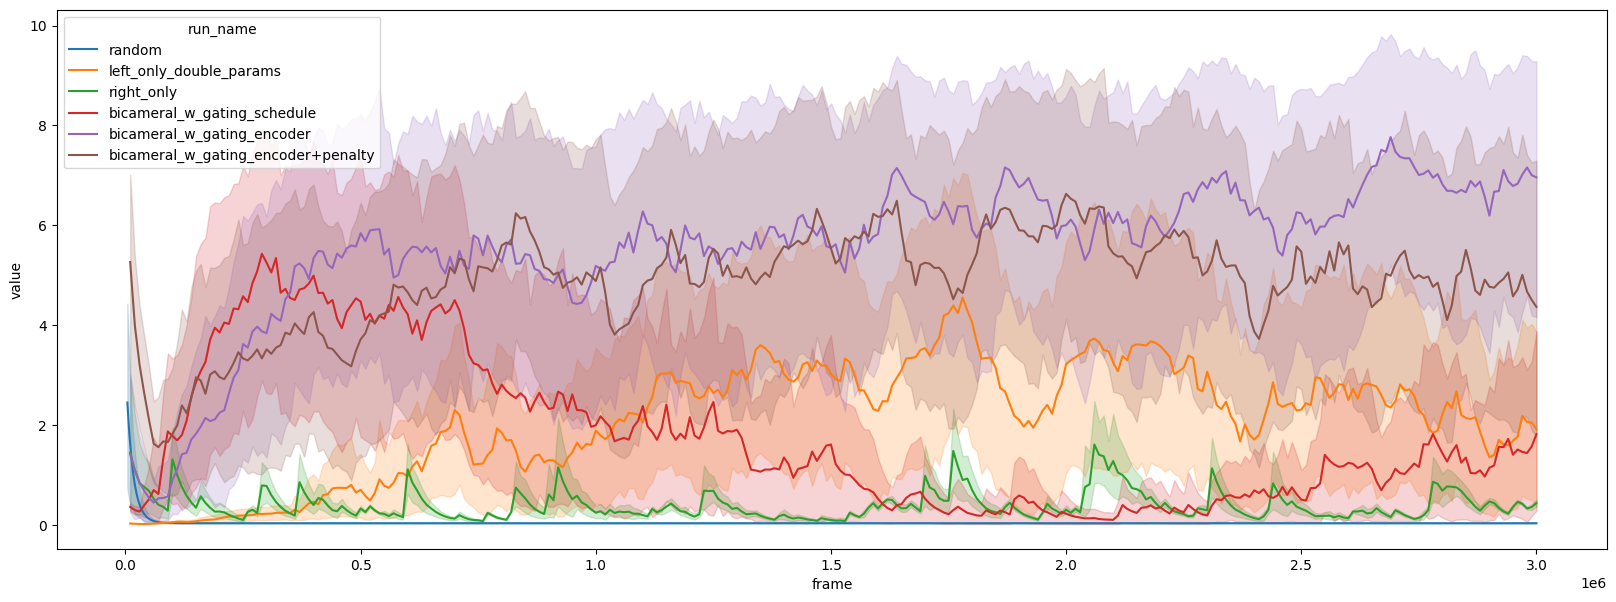

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (20, 7))

sns.lineplot(
    data = (
        train_results
        .query(f'variable.isin({reward_quantiles})')
        .set_index(['result_group', 'run_name', 'frame', 'variable'])
        .ewm(alpha = 0.25)
        .mean()
    ),
    x = 'frame',
    y = 'value',
    hue = 'run_name'
)

In [113]:
left_only_results = resultSet(
    root = '../logs/baselines/left_only_double_73/random_init_fixed20_std0.5_push-v2_left_only_2802_180500',
    name = 'left_only_push-v2'
)

gate_lg_penalty_results = resultSet(
    root = '../logs/baselines/bicameral_net_73/random_init_fixed20_gatepenlg_push-v2_bicameral_2802_180026',
    name = 'bicam_gate_penalty_push-v2'
)

right_only_results = resultSet(
    root = '../logs/baselines/right_only_73/baseline_random_init_all_push-v2_right_only_2302_083607',
    name = 'right_only_push-v2'
)

#### Compare whole bicameral to left_only network

In [117]:
avg_right_reward = right_only_results.data.reward_mean.mean()
avg_right_success = right_only_results.data.num_successes.mean()
combined_data = (
    pd.concat(
        [
            left_only_results.data, 
            (
                gate_lg_penalty_results
                .data
                .query('result_group.isin(["test_results", "train_results"])')
            )
        ]
    )
)


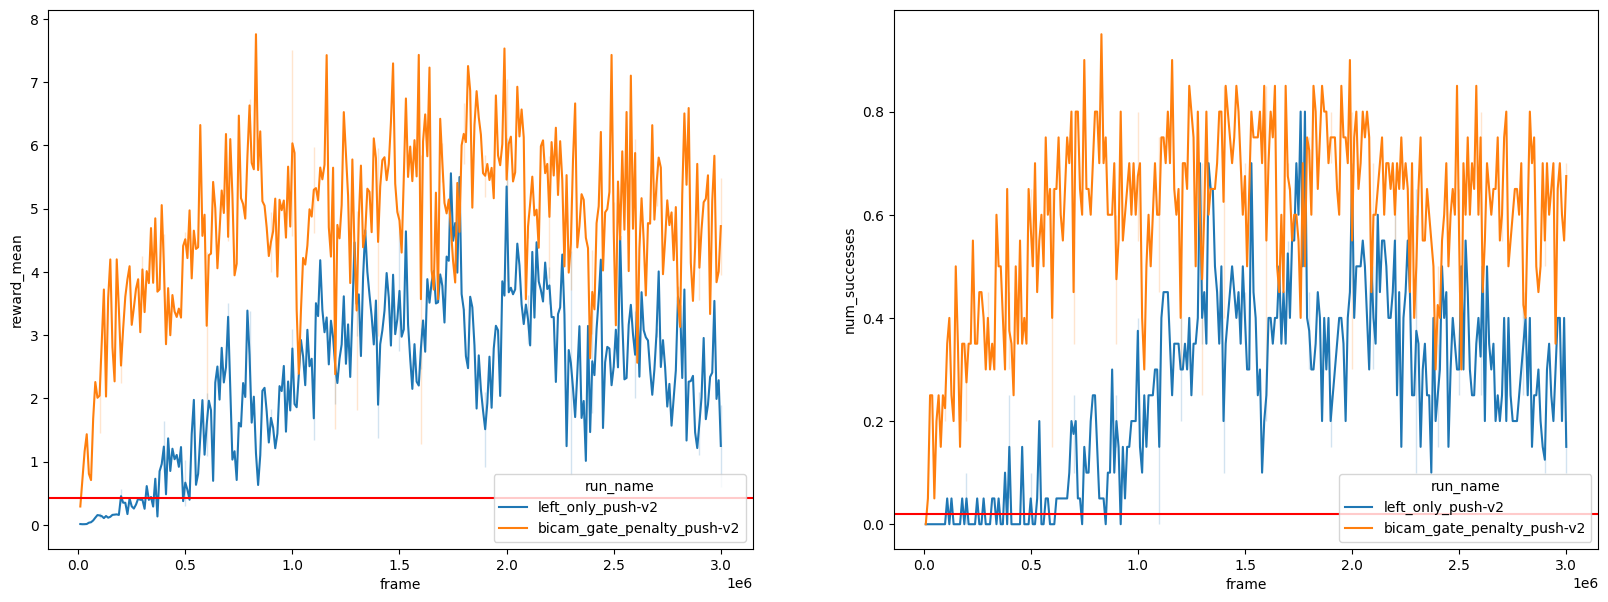

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

ax[0].axhline(avg_right_reward, c='r')

## successes
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

ax[1].axhline(avg_right_success, c='r')

<Axes: xlabel='frame', ylabel='rq_0.9'>

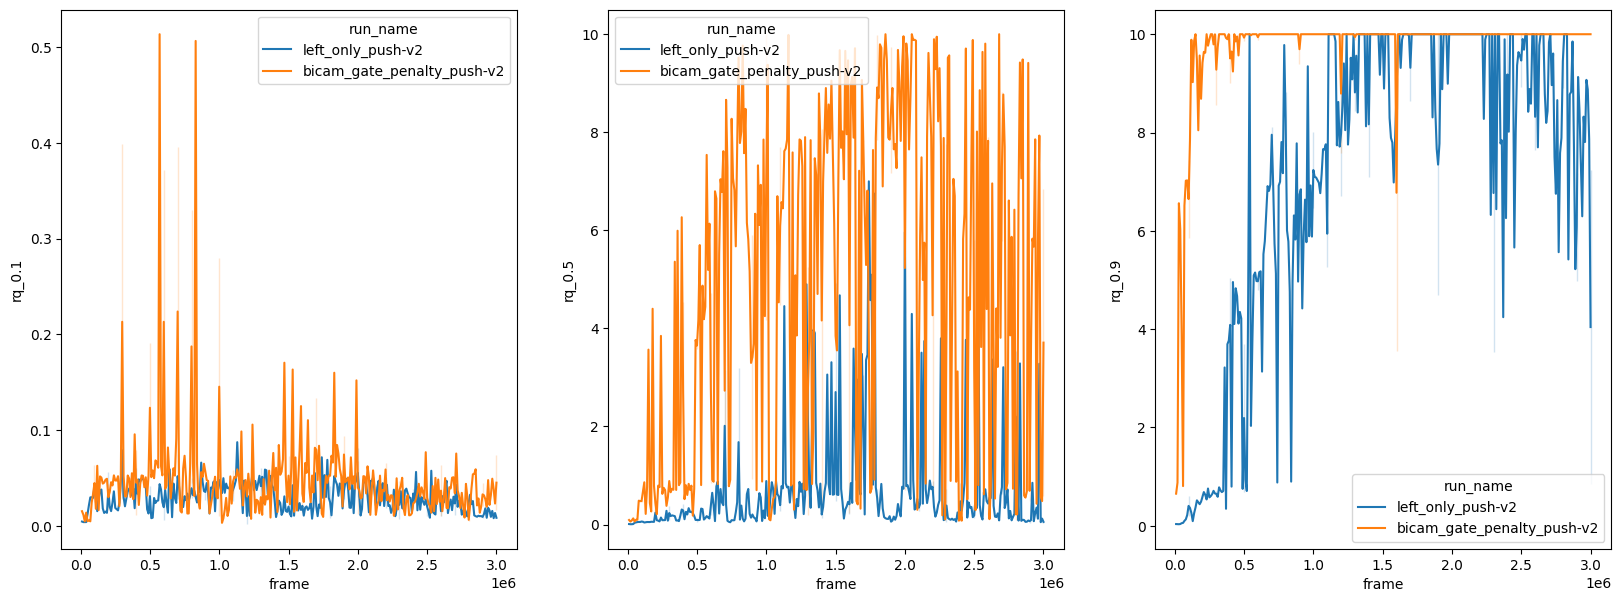

In [123]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

## lowest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.1',
    hue = 'run_name',
    ax = ax[0]
)

## median
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.5',
    hue = 'run_name',
    ax = ax[1]
)

# highest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.9',
    hue = 'run_name',
    ax = ax[2]
)

#### Compare left bicameral to left_only network

In [112]:
combined_plot_df = (
    pd.concat([
        (
            left_only_results
            .data
            .query('result_group=="test_results"')
        ), 
        (
            gate_lg_penalty_results
            .data
            .query('result_group=="left_eval_results"')
        )
    ])
    .loc[:, 
    ['result_group', 'frame', 'run_name', 'num_successes', 'reward_mean'] +\
    [f"rq_{i/10}" for i in range(1, 10)] + [f"gq_{i/10}" for i in range(1, 10)]
    ]
)

    

<Axes: xlabel='frame', ylabel='num_successes'>

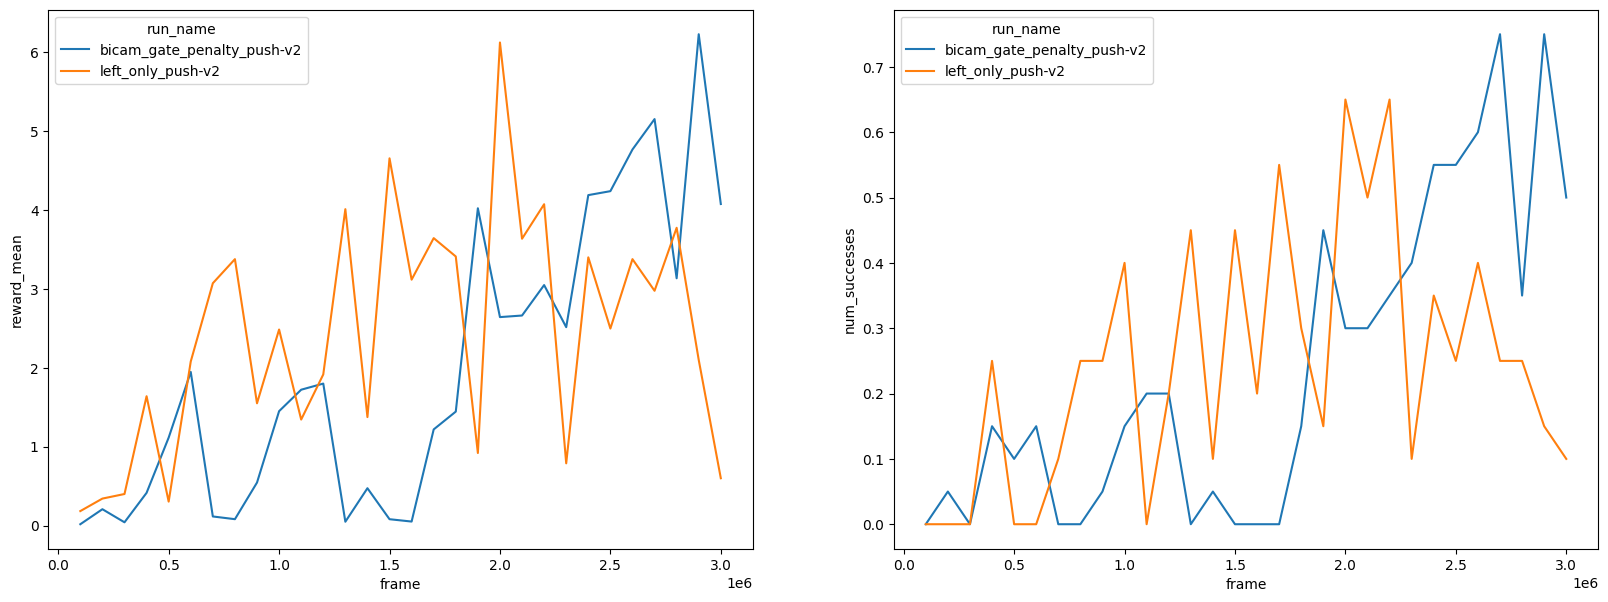

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

## successes
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

<Axes: xlabel='frame', ylabel='value'>

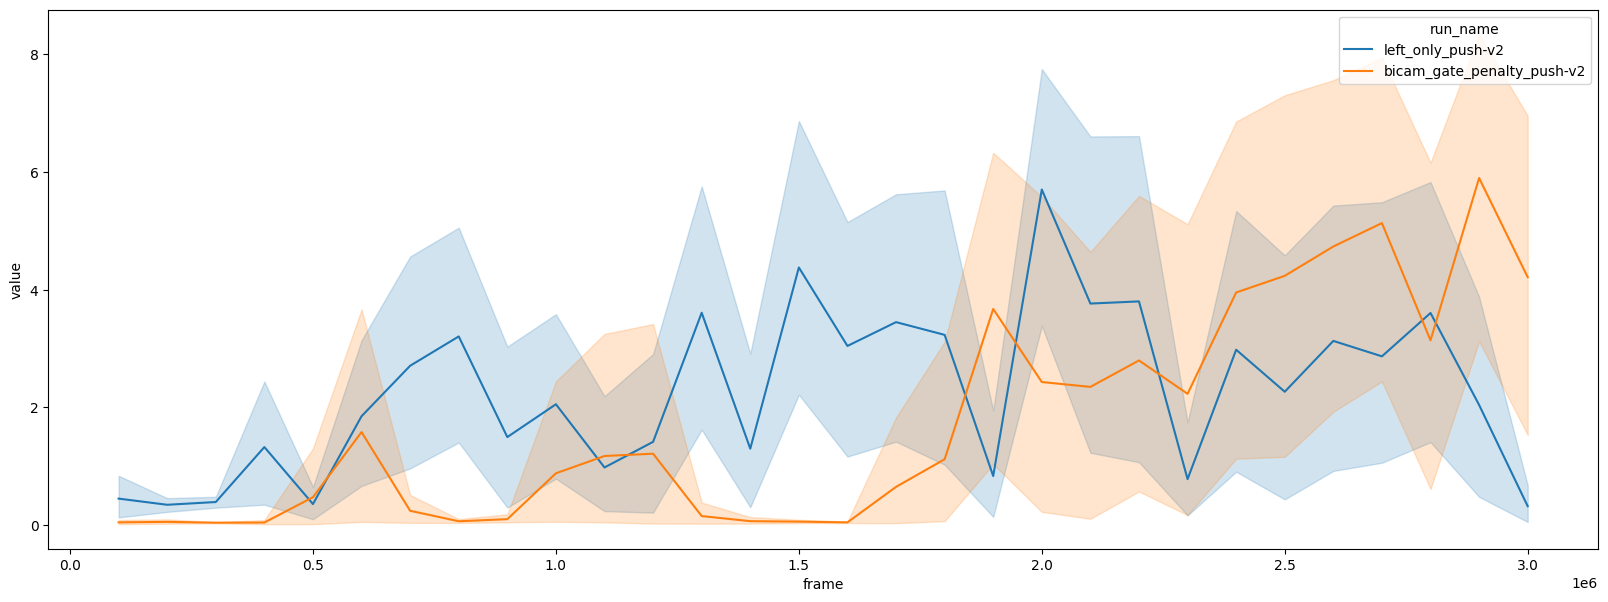

In [136]:
reward_qtiles = (
    combined_plot_df
    .melt(
        id_vars = ['result_group', 'run_name', 'frame'],
        value_vars = [f'rq_{i/10}' for i in range(1, 10)]
    )
    .set_index(['result_group', 'run_name', 'frame', 'variable'])
    .ewm(alpha = 0.9).mean()
)

fig, ax = plt.subplots(figsize = (20, 7))
sns.lineplot(
    data = reward_qtiles,
    x = 'frame',
    y = 'value',
    hue = 'run_name',
    ax = ax
)

<Axes: xlabel='frame', ylabel='rq_0.9'>

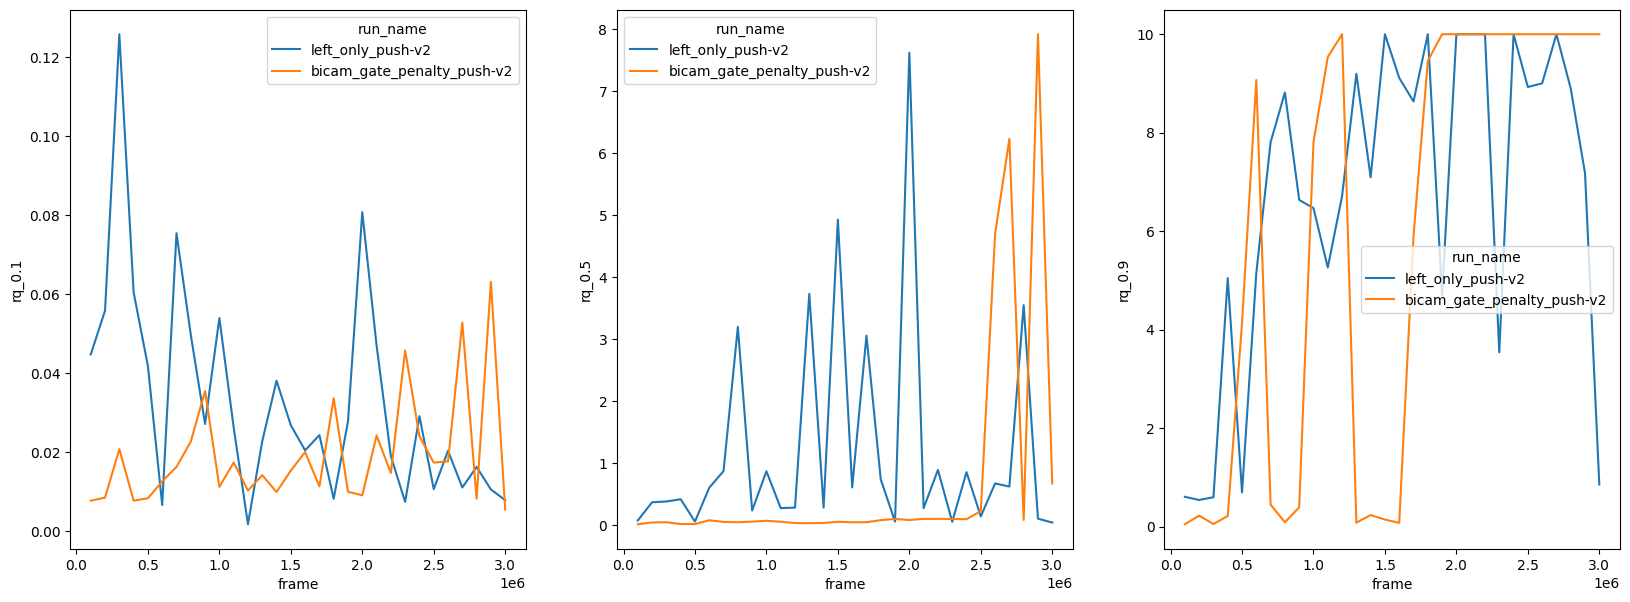

In [81]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

## lowest decile
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'rq_0.1',
    hue = 'run_name',
    ax = ax[0]
)

## median
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'rq_0.5',
    hue = 'run_name',
    ax = ax[1]
)

# highest decile
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'rq_0.9',
    hue = 'run_name',
    ax = ax[2]
)

In [56]:
gv_plot_data = (
    gate_lg_penalty_results
    .data
    .melt(
        id_vars=['training_task', 'frame', 'result_group', 'run_name'],
        value_vars = [f'gq_{i/10}' for i in range(1,10)]
    )
    .query('result_group != "left_eval_results"')
)

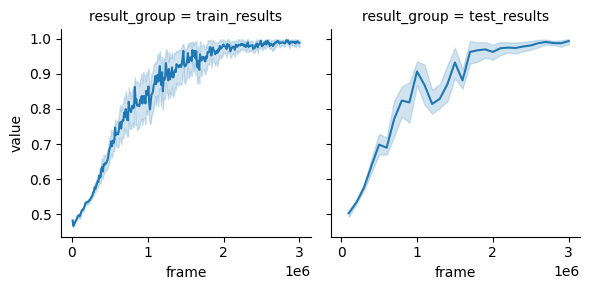

In [124]:
# sns.lineplot(
#     data = gv_plot_data,
#     x = 'frame',
#     y = 'value',
#     hue = 'variable'
# )

g = sns.FacetGrid(
    gv_plot_data.loc[:, ['result_group', 'frame', 'variable', 'value']], col='result_group')
g.map(
    sns.lineplot, "frame", "value"
)

In [7]:
df = pd.Series()
df['col'] = 0
df

col    0
dtype: int64

### Push-v2 Initial Runs

In [ ]:
left_only_

In [46]:
import json

In [88]:
ROOT = '../logs/results/'
test_results = pd.read_csv(os.path.join(ROOT, 'CL_left_only_1302_072547/test_results.csv'))
train_results = pd.read_csv(os.path.join(ROOT, 'CL_left_only_1302_072547/train_results.csv'))

In [73]:
config = pd.read_json(os.path.join(ROOT, 'CL_left_only_1302_183405/config.json'), typ='series')


In [91]:
config

algorithm                                                         left_only
run_folder                        ./logs/logs_ML3-v2/rl2_73__13:02_06:56:06
log_folder                                       ./logs/continual_learning/
env_name                                                           reach-v2
steps_per_env                                                       1000000
rollout_len                                                             500
num_processes                                                            20
randomization                                               random_init_all
init_std                                                                0.5
use_gating_penalty                                                    False
gating_alpha                                                           0.75
gating_beta                                                             0.1
use_gating_schedule                                                   False
gating_sched

In [90]:
def read_in_data(root: str, configs_to_get: list[str] = None):
    out = pd.DataFrame()
    for _folder in os.listdir(ROOT):
        config_dir = os.path.join(ROOT, _folder, 'config.json')
        data_dir = os.path.join(ROOT, _folder)
        config = pd.read_json(config_dir, typ='series')
        train_results = (
            pd.read_csv(os.path.join(data_dir, 'train_results.csv'))
            .assign(batch = 'train')
        )
        test_results = (
            pd.read_csv(os.path.join(data_dir, 'test_results.csv'))
            .assign(batch = 'test')
        )
        test_and_train = (
            pd.concat([train_results, test_results])
            .assign(run = _folder)
        )
        for key in configs_to_get:
            if key in config:
                test_and_train[key] = config[key]
            else:
                test_and_train[key] = None

        out = pd.concat([out, test_and_train])

    return out

In [94]:
all_results = read_in_data('./logs/results', configs_to_get=['algorithm', 'entropy_coef', 'randomization'])

<Axes: xlabel='frame', ylabel='num_successes'>

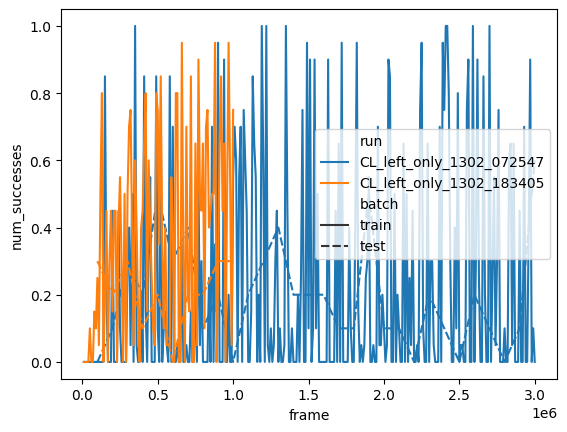

In [99]:
sns.lineplot(
    data = all_results,
    x = 'frame',
    y = 'num_successes',
    hue = 'run',
    style = 'batch'
)

In [67]:
for _folder in os.listdir(ROOT):
    config = pd.read_json(os.path.join(ROOT, _folder, 'config.json'), typ='series')
    print(_folder, config['algorithm'])


CL_left_only_04_02_21_23_12 left_only
CL_left_only_06_02_08_42_26 left_only
CL_left_only_1002_083314 left_only
CL_left_only_1002_101404 left_only
CL_left_only_1302_072547 left_only
CL_left_only_1302_182850 left_only
CL_left_only_1302_182929 left_only
CL_left_only_1302_183405 left_only
CL_left_only_1302_200427 left_only
CL_left_only_1302_200550 left_only
CL__28_01_13_05_25 left_only


In [54]:
os.listdir(ROOT)

['CL_left_only_04_02_21_23_12',
 'CL_left_only_06_02_08_42_26',
 'CL_left_only_1002_083314',
 'CL_left_only_1002_101404',
 'CL_left_only_1302_072547',
 'cl_run-33550576.err',
 'cl_run-33550576.out',
 'cl_run-33719509.err',
 'cl_run-33719509.out',
 'cl_run-33719510.err',
 'cl_run-33719510.out',
 'CL__28_01_13_05_25']

In [5]:
train_results.head()

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,rq_0.1,rq_0.2,rq_0.3,rq_0.4,rq_0.5,...,gq_0.1,gq_0.2,gq_0.3,gq_0.4,gq_0.5,gq_0.6,gq_0.7,gq_0.8,gq_0.9,frame
0,reach-v2,reach-v2,0.0,20,0.975141,0.427389,0.429442,0.432799,0.442774,0.521450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000
1,reach-v2,reach-v2,0.0,20,0.682242,0.365555,0.366967,0.369122,0.373841,0.418074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000
2,reach-v2,reach-v2,0.0,20,0.789959,0.431068,0.432544,0.434740,0.438463,0.462727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000
3,reach-v2,reach-v2,0.0,20,1.122744,0.616197,0.618016,0.620480,0.624918,0.635964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000
4,reach-v2,reach-v2,0.0,20,1.802965,1.095419,1.101497,1.109694,1.124968,1.160115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000


In [63]:
test_results

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,rq_0.1,rq_0.2,rq_0.3,rq_0.4,rq_0.5,...,gq_0.1,gq_0.2,gq_0.3,gq_0.4,gq_0.5,gq_0.6,gq_0.7,gq_0.8,gq_0.9,frame
0,reach-v2,reach-v2,0.2,10,4.240238,1.950413,2.083142,2.155280,2.905268,3.241199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000
1,reach-v2,reach-v2,0.0,10,4.135596,1.679531,2.035418,2.663036,3.205423,3.329390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000
2,reach-v2,reach-v2,0.4,10,4.772492,1.314245,1.776922,1.893913,3.158788,4.415630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000
3,reach-v2,reach-v2,0.2,10,7.056900,4.593688,6.211491,6.500373,7.197230,7.491727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200000
4,reach-v2,reach-v2,0.2,10,5.306758,3.204727,3.761866,4.045170,4.122608,4.332521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150000
5,reach-v2,reach-v2,0.4,10,5.443479,2.513839,3.424185,4.057710,4.590013,4.779148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300000
6,reach-v2,reach-v2,0.3,10,5.902315,2.534188,3.825741,4.656040,4.940518,5.222967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200000
7,reach-v2,reach-v2,0.3,10,6.921462,3.072931,4.635256,5.618713,6.353990,7.338427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400000
8,reach-v2,reach-v2,0.1,10,4.908529,2.477204,2.916991,3.106665,3.342605,3.550247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250000
9,reach-v2,reach-v2,0.2,10,5.034652,1.770275,2.934744,3.424462,4.099204,5.318305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500000


<Axes: xlabel='frame', ylabel='reward_mean'>

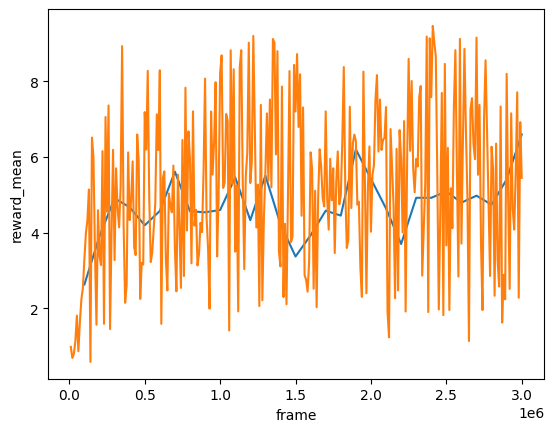

In [86]:
sns.lineplot(
    data = test_results,
    x = 'frame',
    y = 'reward_mean'
)

sns.lineplot(
    data = train_results,
    x = 'frame',
    y = 'reward_mean'
)

<Axes: xlabel='frame'>

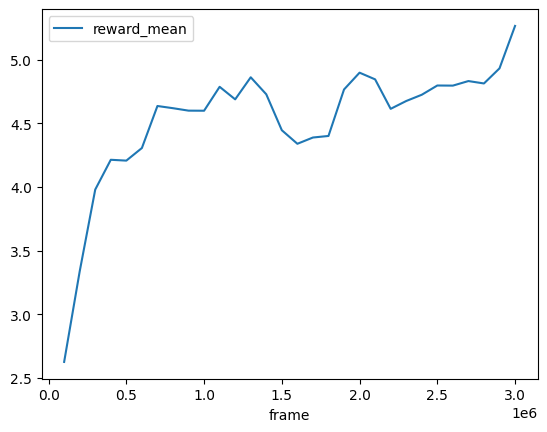

In [87]:
test_results.loc[:,['frame','reward_mean']].set_index('frame').ewm(alpha = 0.2).mean().plot()


<Axes: xlabel='frame'>

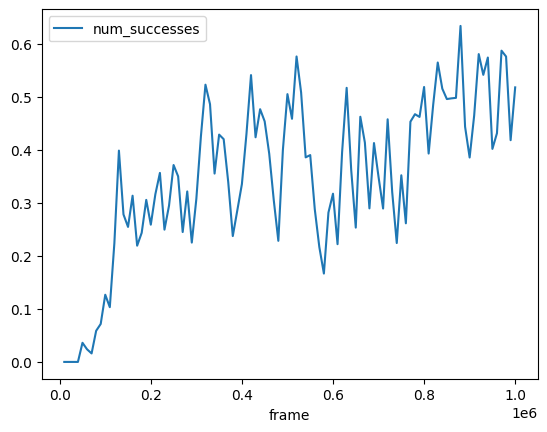

In [81]:
train_results.loc[:,['frame','num_successes']].set_index('frame').ewm(alpha = 0.3).mean().plot()

<Axes: xlabel='frame', ylabel='value'>

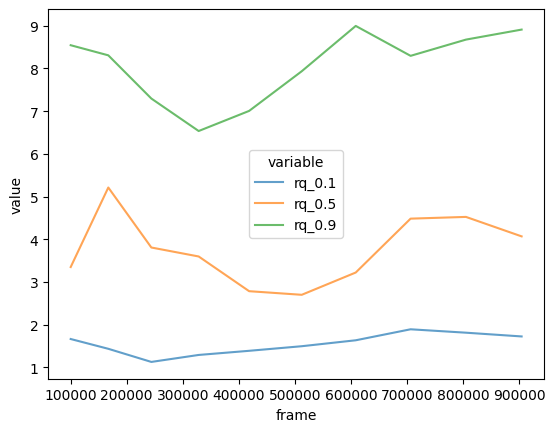

In [84]:
reward_qtiles = (
    test_results
    .melt(
        id_vars = 'frame', # and run
        value_vars = ['rq_' + str(i/10) for i in range(1, 10)]
    )
    .query('variable in ["rq_0.1", "rq_0.5", "rq_0.9"]')
    .groupby('variable')
    .ewm(alpha = 0.51)
    .mean()
)

sns.lineplot(
    data = reward_qtiles,
    x = 'frame',
    y = 'value',
    hue = 'variable',
    alpha = 0.7
)

In [30]:
reward_qtiles

frame     value
variable                             
rq_0.1   0     1.000000e+04  0.427389
         1     1.555556e+04  0.393037
         2     2.147541e+04  0.408623
         3     2.775068e+04  0.478939
         4     3.436935e+04  0.662328
...                     ...       ...
rq_0.9   2695  2.920000e+06  7.257972
         2696  2.930000e+06  7.806377
         2697  2.940000e+06  7.437973
         2698  2.950000e+06  7.723669
         2699  2.960000e+06  7.590217

[900 rows x 2 columns]